In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency, mannwhitneyu

In [2]:
fraud_df = pd.read_csv("data/Fraud_Data.csv")
ip_mapping = pd.read_csv("data/IpAddress_to_Country.csv")

In [3]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
fraud_df.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [5]:
fraud_df.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

In [6]:
non_fraud = fraud_df["class"]==0
fraud = fraud_df["class"]==1

## Distribution of Fraudulent and Non-Fraudulent Transactions

In [7]:
fraud_df["class"].value_counts(normalize=True)

class
0    0.906354
1    0.093646
Name: proportion, dtype: float64

## Number of Transactions by User, Device and IP Address
This section shows how many transactions were made by each `user_id`, `device_id`, and `ip_address`.

In [8]:
def num_transactions_by_id(df, cols=["user_id", "device_id", "ip_address"]):
    for col in cols:
        df[f"transactions_by_{col}"] = df.groupby(col)[col].transform('count')
    return df

In [9]:
df = num_transactions_by_id(fraud_df)

In [10]:
df["transactions_by_user_id"].value_counts()

transactions_by_user_id
1    151112
Name: count, dtype: int64

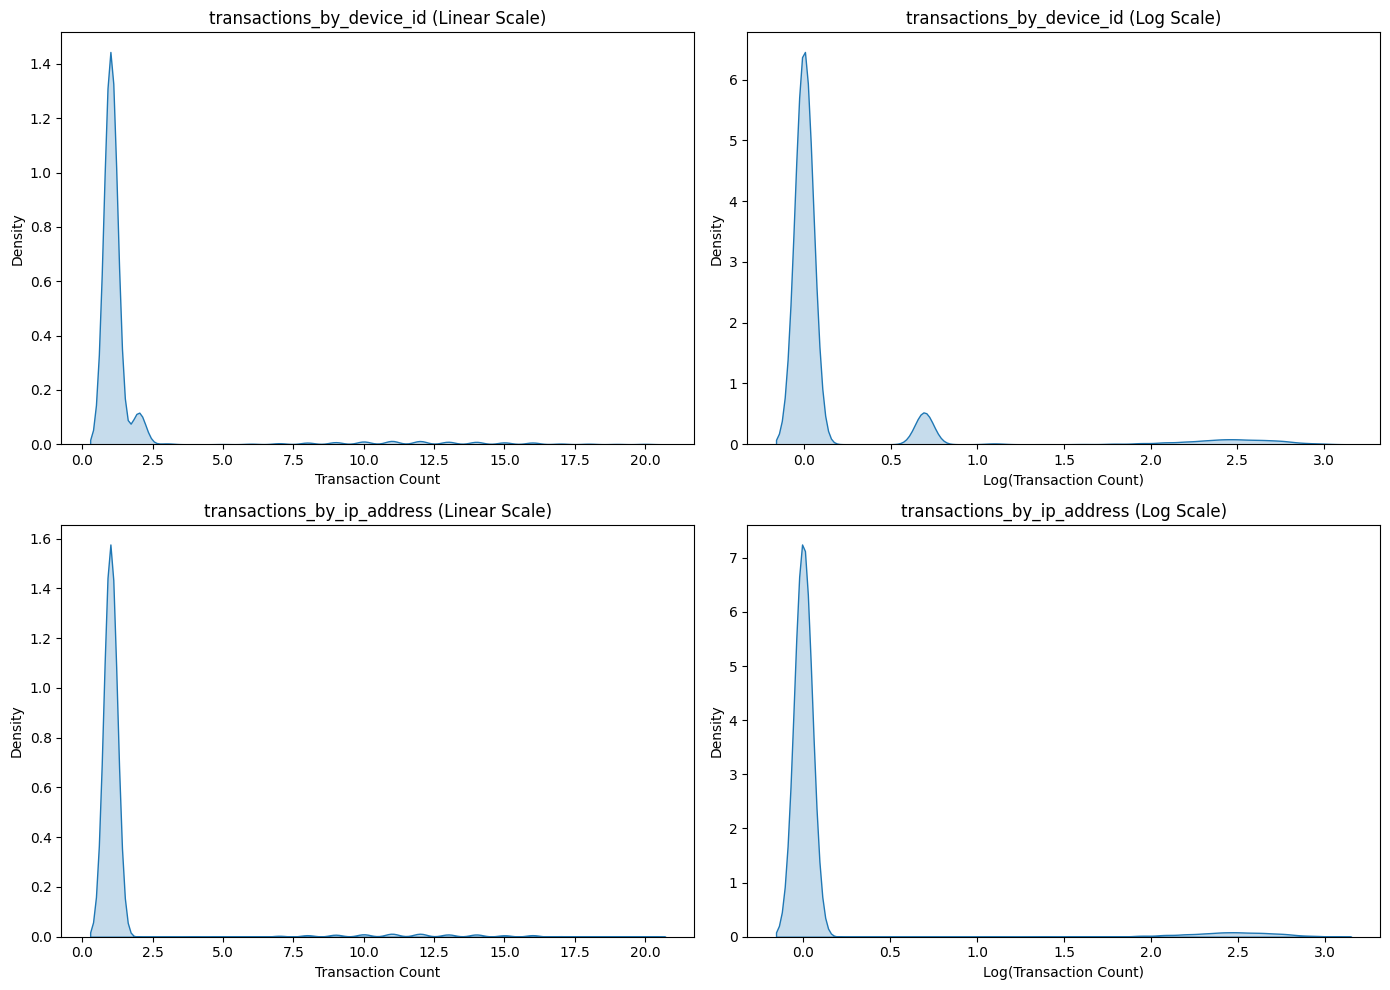

In [11]:
def plot_transaction_distributions(df, cols=["transactions_by_device_id", "transactions_by_ip_address"]):
    """
    Plot KDE distributions for given transaction columns.
    For each column, plot linear and log-scaled KDEs.
    """
    fig, axes = plt.subplots(len(cols), 2, figsize=(14, 5 * len(cols)))

    if len(cols) == 1:
        axes = [axes]  # make it iterable if only one row

    for i, col in enumerate(cols):
        # Linear scale KDE
        sns.kdeplot(data=df, x=col, fill=True, ax=axes[i][0])
        axes[i][0].set_title(f"{col} (Linear Scale)")
        axes[i][0].set_xlabel("Transaction Count")

        # Log scale KDE
        sns.kdeplot(data=df, x=np.log(df[col]), fill=True, ax=axes[i][1])
        axes[i][1].set_title(f"{col} (Log Scale)")
        axes[i][1].set_xlabel("Log(Transaction Count)")

    plt.tight_layout()
    plt.show()

plot_transaction_distributions(df)

Despite applying log transformation to `transactions_by_device_id` and `transactions_by_ip_address`, there are still outliers. Investigate if the outliers are due to the transaction being fraudulent or not.

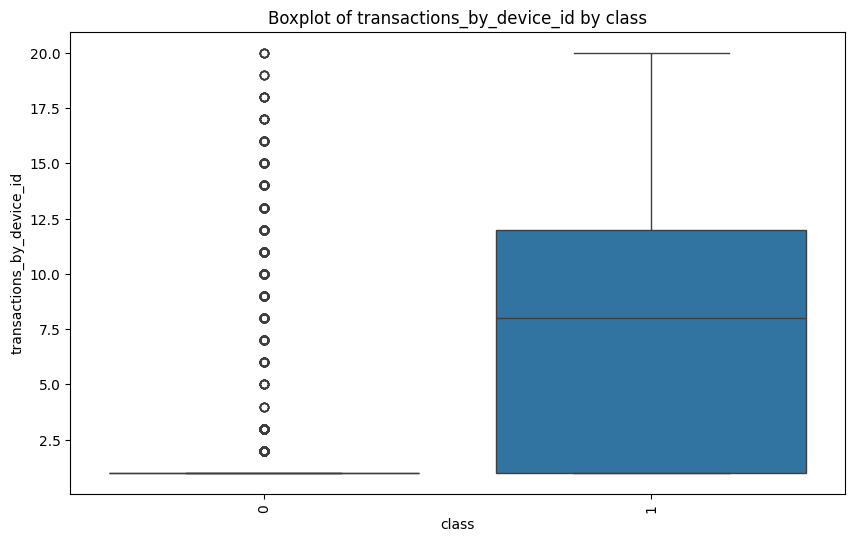

Outliers by class for transactions_by_device_id:
class
0    9190
1       0
dtype: int64




/var/folders/l3/pxhbl0b94cdd7tr_xs9sbypc0000gn/T/ipykernel_1516/3698928097.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outlier_counts = df.groupby(class_column).apply(


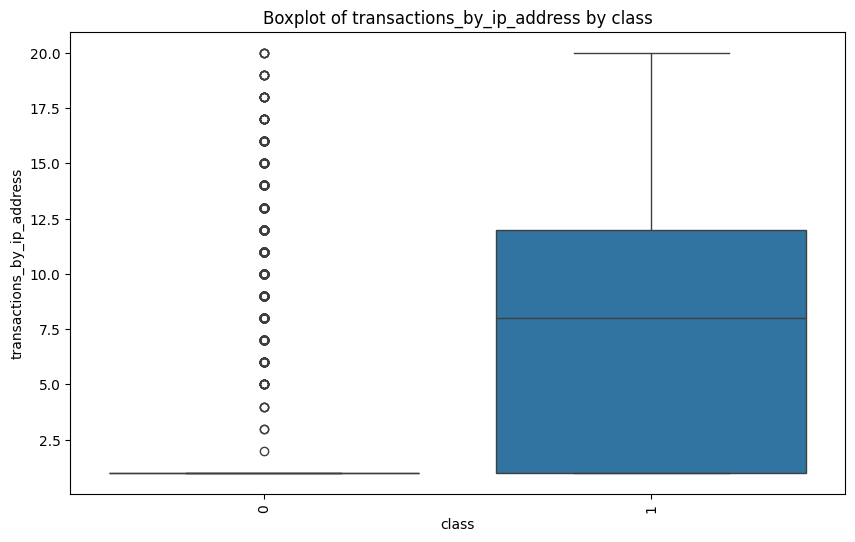

Outliers by class for transactions_by_ip_address:
class
0    726
1      0
dtype: int64




/var/folders/l3/pxhbl0b94cdd7tr_xs9sbypc0000gn/T/ipykernel_1516/3698928097.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outlier_counts = df.groupby(class_column).apply(


In [12]:
def plot_boxplot_by_class(df, columns=['transactions_by_device_id', 'transactions_by_ip_address'], class_column='class'):
    # Loop through each column (transactions) to create boxplots
    for column in columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=class_column, y=column, data=df)
        plt.title(f"Boxplot of {column} by {class_column}")
        plt.xlabel(f"{class_column}")
        plt.ylabel(f"{column}")
        plt.xticks(rotation=90)  # Rotate x-axis labels if needed
        plt.show()

        # Identifying outliers by class (using IQR method)
        outlier_counts = df.groupby(class_column).apply(
            lambda x: ((x[column] < x[column].quantile(0.25) - 1.5 * (x[column].quantile(0.75) - x[column].quantile(0.25))) | 
                       (x[column] > x[column].quantile(0.75) + 1.5 * (x[column].quantile(0.75) - x[column].quantile(0.25)))).sum()
        )

        # Print out the number of outliers for each class
        print(f"Outliers by class for {column}:")
        print(outlier_counts)
        print("\n")

# Example usage
plot_boxplot_by_class(df)


In [13]:
df.groupby("class")["transactions_by_device_id"].value_counts(normalize=True)

class  transactions_by_device_id
0      1                            0.932901
       2                            0.059973
       3                            0.001489
       11                           0.000745
       10                           0.000679
       12                           0.000643
       9                            0.000570
       8                            0.000504
       13                           0.000475
       14                           0.000423
       7                            0.000358
       15                           0.000343
       16                           0.000277
       6                            0.000219
       17                           0.000102
       5                            0.000095
       18                           0.000080
       4                            0.000044
       20                           0.000044
       19                           0.000037
1      1                            0.283372
       2              

In [14]:
df.groupby("class")["transactions_by_ip_address"].value_counts(normalize=True)

class  transactions_by_ip_address
0      1                             0.994699
       11                            0.000686
       10                            0.000635
       12                            0.000635
       9                             0.000555
       8                             0.000504
       13                            0.000438
       14                            0.000409
       7                             0.000343
       15                            0.000263
       16                            0.000256
       6                             0.000212
       5                             0.000095
       17                            0.000088
       18                            0.000066
       19                            0.000044
       20                            0.000029
       4                             0.000022
       3                             0.000015
       2                             0.000007
1      1                             0.460533


Non-fraudulent transactions (Class 0) exhibit a more distributed and irregular pattern, with a significant number of devices and IP addresses making just one transaction. Specifically, 127,771 devices and 136,235 IP addresses in Class 0 are associated with only a single transaction, indicating that the majority of legitimate users interact with the system via a single device or IP address, typically only once. This creates a clear, concentrated peak at one transaction per device or IP.

In contrast, fraudulent transactions (Class 1) show a more concentrated but less extreme pattern. While the distribution is still more regular compared to Class 0, it lacks the large number of extreme outliers seen in the non-fraudulent group. Instead, many of the fraudulent transactions are spread across a smaller number of devices/IPs, with a moderate number of transactions per device or IP address. This suggests that, while fewer devices and IPs are involved overall, they tend to generate a moderate number of transactions. This pattern may indicate that fraudsters often use the same device or IP for multiple transactions, but not in extreme, single-device/IP clusters as seen in non-fraudulent transactions.

In summary, the lack of extreme outliers in Class 1 (fraudulent) reflects a situation where a relatively small number of devices and IP addresses make several transactions, rather than the pattern in Class 0, where the majority of devices/IPs make just one transaction. This highlights the repeated, albeit less extreme nature of fraudulent activities compared to the largely one-time usage pattern seen with legitimate users.

### Create `country` by mapping `ip_address` in `fraud_df` to `country` in `ip_mapping`.

In [15]:
sorted(ip_mapping.values.tolist(), key=lambda x: x[0])

[[16777216.0, 16777471, 'Australia'],
 [16777472.0, 16777727, 'China'],
 [16777728.0, 16778239, 'China'],
 [16778240.0, 16779263, 'Australia'],
 [16779264.0, 16781311, 'China'],
 [16781312.0, 16785407, 'Japan'],
 [16785408.0, 16793599, 'China'],
 [16793600.0, 16809983, 'Japan'],
 [16809984.0, 16842751, 'Thailand'],
 [16842752.0, 16843007, 'China'],
 [16843008.0, 16843263, 'Australia'],
 [16843264.0, 16843775, 'China'],
 [16843776.0, 16844799, 'China'],
 [16844800.0, 16846847, 'China'],
 [16846848.0, 16850943, 'China'],
 [16850944.0, 16859135, 'China'],
 [16859136.0, 16875519, 'Japan'],
 [16875520.0, 16908287, 'Thailand'],
 [16908288.0, 16908799, 'China'],
 [16908800.0, 16909055, 'China'],
 [16909056.0, 16909311, 'Australia'],
 [16909312.0, 16909567, 'China'],
 [16909568.0, 16909823, 'China'],
 [16909824.0, 16910335, 'China'],
 [16910336.0, 16910591, 'China'],
 [16910592.0, 16910847, 'China'],
 [16910848.0, 16911359, 'China'],
 [16911360.0, 16912383, 'China'],
 [16912384.0, 16916479, 'C

In [16]:
import logging

def map_ip_to_country(ip_address, ip_mapping):
    ip_mapping_list = ip_mapping.values.tolist()
    ip_mapping_list.sort(key=lambda x: x[0])

    l, r = 0, len(ip_mapping_list)-1

    while l <= r:
        m = (l + r) // 2
        if ip_mapping_list[m][0] <= ip_address <= ip_mapping_list[m][1]:
            return ip_mapping_list[m][2]
        
        elif ip_mapping_list[m][0] > ip_address:
            r = m - 1
        
        elif ip_address > ip_mapping_list[m][1]:
            l = m + 1
    
    logging.warning(f"IP address {ip_address} not found in any range.")
    return None   

def log_and_map_ip_to_country(ip_address, ip_mapping):
    country = map_ip_to_country(ip_address, ip_mapping)
    logging.info(f"IP Address {ip_address} mapped to country: {country}")
    return country

In [17]:
filepath = os.path.join(os.getcwd(), "data/fraud_with_country.csv")
if os.path.exists(filepath):
        df = pd.read_csv(filepath)
else:
        df["country"] = df["ip_address"].apply(lambda x: log_and_map_ip_to_country(x, ip_mapping))

In [18]:
def generate_bargraph(df, value_column, class_column=None):
    """
    Generates a bar graph for the values in the specified column.
    
    Parameters:
        df (pandas.DataFrame): The dataframe containing the data.
        value_column (str): The column name for the values to plot.
        class_column (str, optional): The column name used for separating values by class.
    """
    # Check if the value_column exists in the DataFrame
    if value_column not in df.columns:
        raise ValueError(f"{value_column} does not exist in the DataFrame.")
    
    # If class_column is provided, separate the values by class
    if class_column and class_column in df.columns:
        grouped = df.groupby(class_column)[value_column].sum()
        grouped.plot(kind='bar', color='skyblue', figsize=(10, 6))
        plt.title(f'Bar Graph of {value_column} Grouped by {class_column}')
        plt.xlabel(class_column)
        plt.ylabel(value_column)
    else:
        # If no class_column is provided, just plot the values directly
        df[value_column].plot(kind='bar', color='skyblue', figsize=(10, 6))
        plt.title(f'Bar Graph of {value_column}')
        plt.xlabel('Index')
        plt.ylabel(value_column)

    # Show the plot
    plt.show()

## Distribution of transactions from each country

In [19]:
df["country"].value_counts(normalize=True, dropna=False)

country
United States     0.384146
NaN               0.145362
China             0.079663
Japan             0.048348
United Kingdom    0.029713
                    ...   
Myanmar           0.000007
Vanuatu           0.000007
Dominica          0.000007
Niger             0.000007
Guadeloupe        0.000007
Name: proportion, Length: 182, dtype: float64

In [20]:
df[non_fraud]["country"].value_counts(normalize=True, dropna=False)

country
United States     0.383306
NaN               0.146633
China             0.080278
Japan             0.048123
United Kingdom    0.029300
                    ...   
Myanmar           0.000007
Vanuatu           0.000007
Dominica          0.000007
Niger             0.000007
Guadeloupe        0.000007
Name: proportion, Length: 181, dtype: float64

In [21]:
df[fraud]["country"].value_counts(normalize=True, dropna=False)

country
United States     0.392269
NaN               0.133065
China             0.073705
Japan             0.050526
United Kingdom    0.033708
                    ...   
Malawi            0.000071
Serbia            0.000071
Turkmenistan      0.000071
Macedonia         0.000071
Mauritius         0.000071
Name: proportion, Length: 110, dtype: float64

In [22]:
# Count fraudulent transactions per country
country_stats = (
    df.groupby('country')
    .agg(
        transactions=('class', 'count'),
        frauds=('class', 'sum'),
    )
    .assign(fraud_rate=lambda x: x.frauds / x.transactions)
)

country_stats.sort_values("fraud_rate")

,transactions,frauds,fraud_rate
country,,,
Kyrgyzstan,18,0,0.000000
Maldives,2,0,0.000000
Madagascar,1,0,0.000000
Macau,10,0,0.000000
Liechtenstein,2,0,0.000000
...,...,...,...
Virgin Islands (U.S.),3,1,0.333333
Luxembourg,72,28,0.388889
Sri Lanka,31,13,0.419355


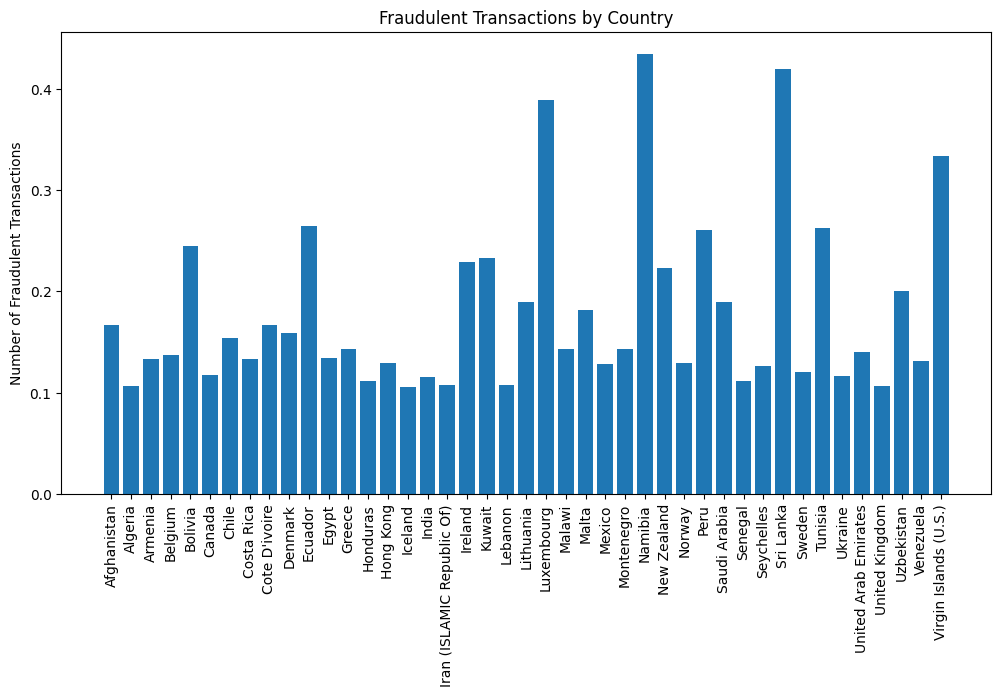

In [23]:
filtered_country_stats = country_stats[(country_stats['fraud_rate'] > 0.1) & (country_stats["transactions"] > 1)]
plt.figure(figsize=(12,6))
plt.bar(filtered_country_stats.index, filtered_country_stats['fraud_rate'])
plt.xticks(rotation=90)
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Fraudulent Transactions by Country')
plt.show()

### Device-IP Consistency
`device_ip_consistency` ensures that each device is tied to exactly one IP address and vice versa, which is important for tracking legitimate access patterns. If a device is used from multiple IPs or if multiple devices are sharing the same IP, it could raise concerns for system misuse or fraud.

### User-Level Consistency
`device_ip_user_consistency` goes a step further by considering user-level consistency. This helps to flag cases where multiple users may be accessing the same device or IP, which could be a sign of account sharing, misconfiguration, or even fraudulent activity.

In [24]:
# rename transactions_by_device_id and transactions_by_ip_address to users_by_device_id and users_by_ip_address
df = df.rename(columns={'transactions_by_device_id': 'users_by_device_id', 'transactions_by_ip_address': 'users_by_ip_address'})

In [25]:
def device_ip_counts(df):
    devices_by_ip = df.groupby("ip_address").agg({"device_id":"nunique"}).to_dict()["device_id"]
    ip_by_device = df.groupby("device_id").agg({"ip_address":"nunique"}).to_dict()["ip_address"]

    df["devices_by_ip"] = df["ip_address"].apply(lambda ip: devices_by_ip[ip])
    df["ip_by_device"] = df["device_id"].apply(lambda device_id: ip_by_device[device_id])

    df["device_ip_consistency"] = (df["devices_by_ip"] == 1) & (df["ip_by_device"] == 1)

    df["device_ip_user_consistency"] = (
    (df["device_ip_consistency"]) &
    (df["users_by_ip_address"] == 1) &
    (df["users_by_device_id"] == 1)
)

    return df


In [26]:
df = device_ip_counts(df)

In [27]:
df[non_fraud]["device_ip_consistency"].value_counts(normalize=True)

device_ip_consistency
True     0.937931
False    0.062069
Name: proportion, dtype: float64

In [28]:
df[fraud]["device_ip_consistency"].value_counts(normalize=True)

device_ip_consistency
True     0.786022
False    0.213978
Name: proportion, dtype: float64

Both fraudulent and non-fraudulent transactions, the vast majority of transactions still maintain `device_ip_consistency`. This suggests that most transactions—whether fraudulent or not—are originating from a single device and IP address.

In [29]:
df[non_fraud]["device_ip_user_consistency"].value_counts(normalize=True)

device_ip_user_consistency
True     0.932901
False    0.067099
Name: proportion, dtype: float64

In [30]:
df[fraud]["device_ip_user_consistency"].value_counts(normalize=True)

device_ip_user_consistency
False    0.716628
True     0.283372
Name: proportion, dtype: float64

Fraudulent transactions exhibit a sharp decline in `device_ip_user_consistency` (only 28.3%).

The drop in consistency for fraudulent transactions is a significant anomaly. It suggests that fraudsters are likely using multiple accounts, possibly from the same device or IP, or engaging in behavior that bypasses standard patterns (e.g., proxy usage, shared devices, etc.).

This discrepancy between normal and fraudulent transactions is a strong indicator of potential fraud, as the fraudulent behavior doesn't follow the same device-IP-user consistency patterns that legitimate transactions do.

## Time Between Signup and Purchase

In [31]:
def signup_purchase_time(df):
    # convert to datetime
    df["signup_time"] = pd.to_datetime(df["signup_time"])
    df["purchase_time"] = pd.to_datetime(df["purchase_time"])

    df["time_between_setup_and_transaction"] = (df["purchase_time"]  - df["signup_time"]).dt.total_seconds()
    
    return df

df = signup_purchase_time(df)

<Axes: xlabel='time_between_setup_and_transaction', ylabel='Density'>

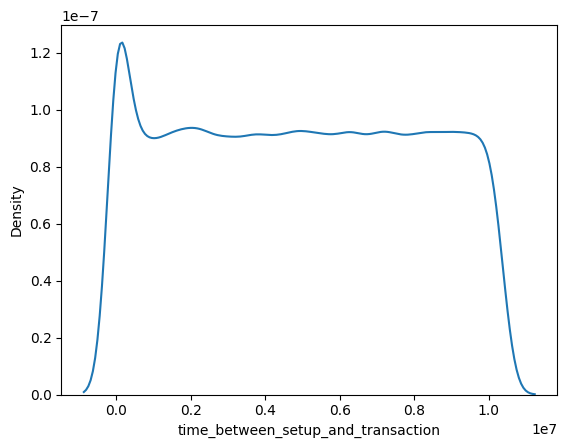

In [32]:
sns.kdeplot(data=df, x="time_between_setup_and_transaction")

<Axes: xlabel='time_between_setup_and_transaction', ylabel='Density'>

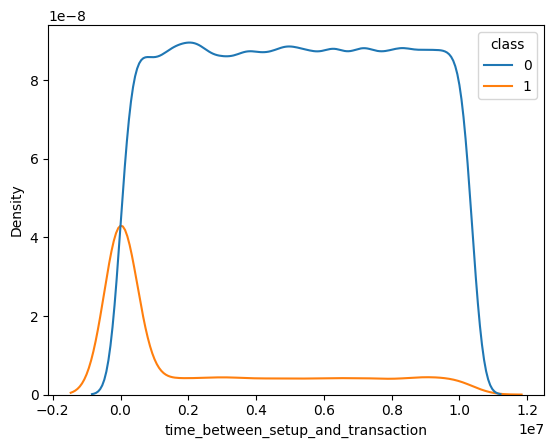

In [33]:
sns.kdeplot(data=df, x="time_between_setup_and_transaction", hue="class")

### Do fraudulent transactions have smaller difference between signup and purchase times than non-fraudulent transactions?

H0: There is no difference 
H1: Fraudulent transactions have smaller (one direction, one-tail) difference between signup and purchase times than non-fraudulent transactions.

Test the hypothesis with Mann-Whitney U test since distribution is not normal. While Mann-Whitney U test assumes that the samples are independent of one another, this may not be the case in the real-world. For example, fraudsters part of the same collusion may be aware of the significance of `time_between_setup_and_transaction` and may intentionally vary this amongst their group.


In [34]:
from scipy.stats import mannwhitneyu, norm

In [35]:
def mannwhitneyu_large(df, fraud_idx, non_fraud_idx):
    n1 = fraud_idx.sum()
    n2 = non_fraud_idx.sum()
    
    # Before running the Mann-Whitney U test, make sure you're using efficient data types.
    df['time_between_setup_and_transaction'] = pd.to_numeric(df['time_between_setup_and_transaction'], downcast='float')

    frauds = df[fraud_idx]["time_between_setup_and_transaction"]
    non_frauds = df[non_fraud_idx]["time_between_setup_and_transaction"]

    p_values = []

    U1, p = mannwhitneyu(frauds, non_frauds, method='asymptotic')
    p_values.append(p)

    return p_values

mannwhitneyu_large(df, fraud, non_fraud)


[np.float64(0.0)]

In [36]:
def time_between_prev_purchase(df, col):
    df = df.sort_values(by=[col, "purchase_time"])
    df[f"time_diff_{col}"] = df.groupby(col)["purchase_time"].diff().dt.seconds
    return df

In [37]:
df = time_between_prev_purchase(df, "device_id")
df = time_between_prev_purchase(df, "ip_address")

<Axes: xlabel='time_diff_device_id', ylabel='Density'>

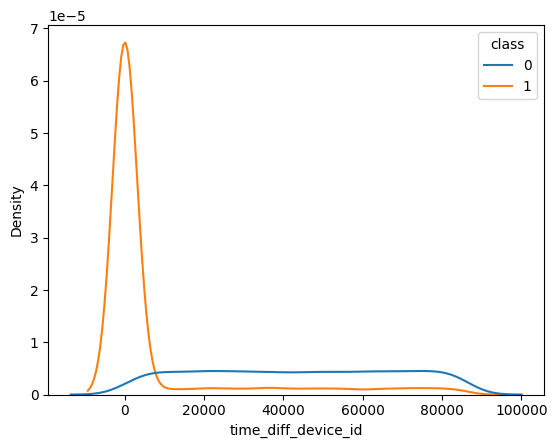

In [38]:
sns.kdeplot(data=df, x="time_diff_device_id", hue="class")

<Axes: xlabel='time_diff_ip_address', ylabel='Density'>

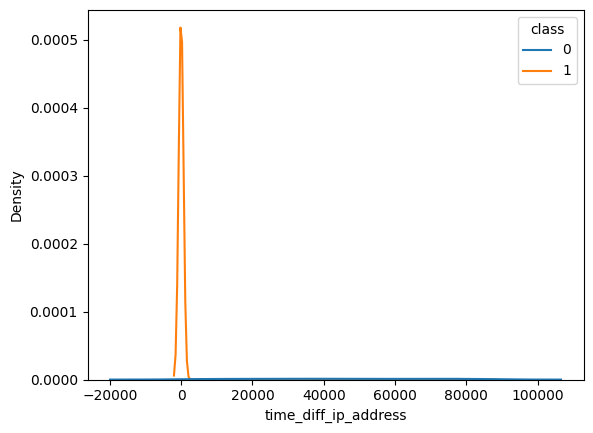

In [39]:
sns.kdeplot(data=df, x="time_diff_ip_address", hue="class")

Out of the transactions that use the same device/ip address, how many of them are fraudulent?

In [40]:
df[df["device_ip_consistency"] == False].groupby("class")["user_id"].count()

class
0    8501
1    3028
Name: user_id, dtype: int64

In [41]:
device_ip_count = df.groupby(["device_id", "ip_address"]).count()

In [42]:
device_ip_count[device_ip_count["user_id"] > 1]

,,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,source,browser,sex,age,class,...,users_by_device_id,users_by_ip_address,country,devices_by_ip,ip_by_device,device_ip_consistency,device_ip_user_consistency,time_between_setup_and_transaction,time_diff_device_id,time_diff_ip_address
device_id,ip_address,,,,,,,,,,,,,,,,,,,,,
AAAXXOZJRZRAO,1.377849e+09,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,10,10
AANYBGQSWHRTK,2.707984e+09,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,7,7
ADEDUDCYQMYTI,2.664872e+09,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,13,13
AENUQLGTUHYMS,2.138534e+09,7,7,7,7,7,7,7,7,7,7,...,7,7,0,7,7,7,7,7,6,6
AIGPGDVRDKOKT,3.058136e+09,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,11,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYHVSPGHWACPO,1.202929e+09,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,5,5
ZYZQZXBXADPST,2.056130e+09,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,15,15
ZZCAWCKYVMWNH,8.480062e+08,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,8,8


Out of all the devices and IPs that have been reused, how many fraudulent transactions come from each of them?

In [43]:
def summarize_entity(df, entity_col):
    """
    Summarize fraud and transaction statistics for either device_id or ip_address.

    Parameters
    ----------
    df : pd.DataFrame
        Dataset containing fraud info.
    entity_col : str
        Either 'device_id' or 'ip_address'.

    Returns
    -------
    pd.DataFrame
        Aggregated statistics per entity.
    """
    # Sanity check
    if entity_col not in ['device_id', 'ip_address']:
        raise ValueError("entity_col must be either 'device_id' or 'ip_address'")

    # Determine opposite entity for unique counting
    other_entity = 'ip_address' if entity_col == 'device_id' else 'device_id'
    other_entity_name = 'unique_ips' if entity_col == 'device_id' else 'unique_device_ids'

    # Build aggregation dictionary
    agg_dict = {
        'class': [('transactions', 'count'), ('frauds', 'sum')],
        'user_id': [('unique_users', 'nunique')],
        other_entity: [(other_entity_name, 'nunique')],
        'purchase_value': [('mean_purchase_val', 'mean'),
                           ('purchase_val_std', 'std')],
        # handle missing safely
        'time_between_setup_and_transaction': [('median_time_between_signup_and_purchase', 'median')],
    }

    # Include correct time diff column
    if entity_col == 'device_id':
        time_col = 'time_diff_device_id'
    else:
        time_col = 'time_diff_ip_address'

    agg_dict[time_col] = [('median_time_between_purchase', 'median')]

    # Perform aggregation
    stats = (
        df.groupby(entity_col)
          .agg(agg_dict)
          .reset_index()
    )

    # Flatten MultiIndex columns (from nested aggregation)
    stats.columns = [entity_col] + [c[1] for c in stats.columns[1:]]

    # Add derived metric: fraud rate
    stats['fraud_rate'] = stats['frauds'] / stats['transactions']

    return stats


median is used for `time_between_purchase` and `time_between_signup_and_purchase` as analysis shows that fraudulent transactions by the same device/id takes place 1s after the previous, and there are transactions that are made by the same device/id that are made way later than the last transaction, and they may not be fraudulent. 

For instance,

Device with id 'AAAXXOZJRZRAO' has a fraud_rate of 0.909091.

This device could have been stolen and subsequently used for fraud, or vice versa: Look into when each transaction was made. A clear separation of `purchase_time` suggests that this was a stolen device, otherwise

This device could have been part of an organised fraud ring. Analysing the purchase value of each transaction
- smaller purchase value for non-fraudulent transactions implies that the fraud ring was testing.
- small difference between purchase value suggests that it was an attempt to look more discreet.

In [44]:
# Justification for using median, instead of mean
df[df["device_id"] == "AAAXXOZJRZRAO"][["signup_time", "purchase_time", "purchase_value", "sex", "age", "time_between_setup_and_transaction", "time_diff_device_id", "time_diff_ip_address", "class"]]

,signup_time,purchase_time,purchase_value,sex,age,time_between_setup_and_transaction,time_diff_device_id,time_diff_ip_address,class
69175,2015-01-01 04:25:22,2015-01-01 04:25:23,57,F,36,1.0,NaN,NaN,1
35860,2015-01-01 04:25:23,2015-01-01 04:25:24,57,F,36,1.0,1.0,1.0,1
115396,2015-01-01 04:25:24,2015-01-01 04:25:25,57,F,36,1.0,1.0,1.0,1
136484,2015-01-01 04:25:25,2015-01-01 04:25:26,57,F,36,1.0,1.0,1.0,1
44484,2015-01-01 04:25:26,2015-01-01 04:25:27,57,F,36,1.0,1.0,1.0,1
65899,2015-01-01 04:25:27,2015-01-01 04:25:28,57,F,36,1.0,1.0,1.0,1
83494,2015-01-01 04:25:28,2015-01-01 04:25:29,57,F,36,1.0,1.0,1.0,1
56146,2015-01-01 04:25:29,2015-01-01 04:25:30,57,F,36,1.0,1.0,1.0,1
138229,2015-01-01 04:25:30,2015-01-01 04:25:31,57,F,36,1.0,1.0,1.0,1
107401,2015-01-01 04:25:31,2015-01-01 04:25:32,57,F,36,1.0,1.0,1.0,1


In [45]:
stats_by_device = summarize_entity(df, "device_id")

In [46]:
stats_by_device[stats_by_device["transactions"] > 2]

,device_id,transactions,frauds,unique_users,unique_ips,mean_purchase_val,purchase_val_std,median_time_between_signup_and_purchase,median_time_between_purchase,fraud_rate
3,AAAXXOZJRZRAO,11,10,11,1,57.0,0.0,1.0,1.0,0.909091
114,AANYBGQSWHRTK,8,7,8,1,42.0,0.0,1.0,1.0,0.875000
645,ADEDUDCYQMYTI,14,13,14,1,52.0,0.0,1.0,1.0,0.928571
919,AENUQLGTUHYMS,7,6,7,1,58.0,0.0,1.0,1.0,0.857143
1733,AIGPGDVRDKOKT,12,11,12,1,21.0,0.0,1.0,1.0,0.916667
...,...,...,...,...,...,...,...,...,...,...
137622,ZYHVSPGHWACPO,6,5,6,1,59.0,0.0,1.0,1.0,0.833333
137774,ZYZQZXBXADPST,16,15,16,1,40.0,0.0,1.0,1.0,0.937500
137790,ZZCAWCKYVMWNH,9,8,9,1,38.0,0.0,1.0,1.0,0.888889
137810,ZZFFPOVMCQVCG,7,6,7,1,21.0,0.0,1.0,1.0,0.857143


In [47]:
stats_by_device[stats_by_device["transactions"] > 1][["transactions", "mean_purchase_val", "purchase_val_std", "median_time_between_signup_and_purchase", "median_time_between_purchase", "fraud_rate"]].corr()

,transactions,mean_purchase_val,purchase_val_std,median_time_between_signup_and_purchase,median_time_between_purchase,fraud_rate
transactions,1.000000,0.000594,-0.375089,-0.609412,-0.488854,0.594005
mean_purchase_val,0.000594,1.000000,0.282386,0.025039,0.017430,0.011738
purchase_val_std,-0.375089,0.282386,1.000000,0.270543,0.231983,-0.251574
median_time_between_signup_and_purchase,-0.609412,0.025039,0.270543,1.000000,0.326326,-0.400067
median_time_between_purchase,-0.488854,0.017430,0.231983,0.326326,1.000000,-0.331059
fraud_rate,0.594005,0.011738,-0.251574,-0.400067,-0.331059,1.000000


In [48]:
stats_by_device[stats_by_device["transactions"] > 2][["transactions", "mean_purchase_val", "purchase_val_std", "median_time_between_signup_and_purchase", "median_time_between_purchase", "fraud_rate"]].corr()

,transactions,mean_purchase_val,purchase_val_std,median_time_between_signup_and_purchase,median_time_between_purchase,fraud_rate
transactions,1.000000,0.028825,-0.524666,-0.574132,-0.594925,0.684414
mean_purchase_val,0.028825,1.000000,0.080331,0.003350,0.016315,-0.015026
purchase_val_std,-0.524666,0.080331,1.000000,0.736403,0.759093,-0.784586
median_time_between_signup_and_purchase,-0.574132,0.003350,0.736403,1.000000,0.788026,-0.818920
median_time_between_purchase,-0.594925,0.016315,0.759093,0.788026,1.000000,-0.824332
fraud_rate,0.684414,-0.015026,-0.784586,-0.818920,-0.824332,1.000000


Filtering transactions to those where the same device has been used more than 2 times has a significant impact on the relationship between `fraud_rate` and `transactions`, `purchase_val_std`, `median_time_between_signup_and_purchase` and `median_time_between_purchase`

this is consistent with:
1. transactions from the same device often have the same `purchase_value`, which means lower `purchase_val_std`
2. transactions from the same device that are made one after another are more likely to be fraudulent.
3. transactions from the same device that are made not long after account set up aare more likely to be fraudulent

In [49]:
stats_by_ip = summarize_entity(df, "ip_address")

In [50]:
stats_by_ip[stats_by_ip["transactions"] > 1]

,ip_address,transactions,frauds,unique_users,unique_device_ids,mean_purchase_val,purchase_val_std,median_time_between_signup_and_purchase,median_time_between_purchase,fraud_rate
68,2.278096e+06,16,15,16,1,26.0,0.0,1.0,1.0,0.937500
223,6.150367e+06,9,9,9,1,30.0,0.0,1.0,1.0,1.000000
598,1.666923e+07,11,10,11,1,34.0,0.0,1.0,1.0,0.909091
649,1.819146e+07,6,5,6,1,15.0,0.0,1.0,1.0,0.833333
928,2.584822e+07,7,6,7,1,27.0,0.0,1.0,1.0,0.857143
...,...,...,...,...,...,...,...,...,...,...
142433,4.262695e+09,13,12,13,1,43.0,0.0,1.0,1.0,0.923077
142856,4.275223e+09,11,10,11,1,41.0,0.0,1.0,1.0,0.909091
142998,4.279796e+09,12,11,12,1,41.0,0.0,1.0,1.0,0.916667
143073,4.281743e+09,7,6,7,1,54.0,0.0,1.0,1.0,0.857143


In [51]:
stats_by_ip[stats_by_ip["transactions"] > 1][["transactions", "mean_purchase_val", "purchase_val_std", "median_time_between_signup_and_purchase", "median_time_between_purchase", "fraud_rate"]].corr()

,transactions,mean_purchase_val,purchase_val_std,median_time_between_signup_and_purchase,median_time_between_purchase,fraud_rate
transactions,1.000000,0.043000,NaN,-0.104144,-0.157091,0.725913
mean_purchase_val,0.043000,1.000000,NaN,0.040350,0.045395,-0.009286
purchase_val_std,NaN,NaN,NaN,NaN,NaN,NaN
median_time_between_signup_and_purchase,-0.104144,0.040350,NaN,1.000000,0.830055,-0.352482
median_time_between_purchase,-0.157091,0.045395,NaN,0.830055,1.000000,-0.450867
fraud_rate,0.725913,-0.009286,NaN,-0.352482,-0.450867,1.000000


In [52]:
stats_by_ip[stats_by_ip["transactions"] > 2][["transactions", "mean_purchase_val", "purchase_val_std", "median_time_between_signup_and_purchase", "median_time_between_purchase", "fraud_rate"]].corr()

,transactions,mean_purchase_val,purchase_val_std,median_time_between_signup_and_purchase,median_time_between_purchase,fraud_rate
transactions,1.000000,0.047499,NaN,NaN,-0.127369,0.740499
mean_purchase_val,0.047499,1.000000,NaN,NaN,0.021359,0.005280
purchase_val_std,NaN,NaN,NaN,NaN,NaN,NaN
median_time_between_signup_and_purchase,NaN,NaN,NaN,NaN,NaN,NaN
median_time_between_purchase,-0.127369,0.021359,NaN,NaN,1.000000,-0.303297
fraud_rate,0.740499,0.005280,NaN,NaN,-0.303297,1.000000


In [53]:
stats_by_device.groupby("transactions")["fraud_rate"].mean()

transactions
1     0.030429
2     0.229022
3     0.244444
4     0.625000
5     0.800000
6     0.827586
7     0.860000
8     0.875000
9     0.888889
10    0.898913
11    0.908191
12    0.918519
13    0.921875
14    0.927318
15    0.923577
16    0.934028
17    0.936652
18    0.938889
19    0.947368
20    0.950000
Name: fraud_rate, dtype: float64

In [54]:
stats_by_ip.groupby("transactions")["fraud_rate"].mean()

transactions
1     0.045653
2     0.500000
3     0.666667
4     0.812500
5     0.800000
6     0.838889
7     0.865714
8     0.878521
9     0.897019
10    0.902247
11    0.914545
12    0.920330
13    0.927885
14    0.932203
15    0.933333
16    0.939236
17    0.941176
18    0.944444
19    0.954887
20    0.950000
Name: fraud_rate, dtype: float64

Device and IP reuse are useful indicators of fraud. Specifically, the more times a device/IP has been reused, the more likely the transaction made is fraudulent.

- useful feature: number of times device/ip has been reused up till purchase time (helps to decrease data leaking)

## Are `source` and `engine` indications of fraud?

In [55]:
df[non_fraud]["source"].value_counts(normalize=True)

/var/folders/l3/pxhbl0b94cdd7tr_xs9sbypc0000gn/T/ipykernel_1516/2360036379.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[non_fraud]["source"].value_counts(normalize=True)


source
SEO       0.403056
Ads       0.396960
Direct    0.199984
Name: proportion, dtype: float64

In [56]:
df[fraud]["source"].value_counts(normalize=True)

/var/folders/l3/pxhbl0b94cdd7tr_xs9sbypc0000gn/T/ipykernel_1516/3592328002.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[fraud]["source"].value_counts(normalize=True)


source
Ads       0.389584
SEO       0.382446
Direct    0.227970
Name: proportion, dtype: float64

Do certain interactions between `source` and `browser` have higher fraud risk?

In [57]:
combo_stats = (
    df.groupby(['source','browser'])
    .agg(
          transactions=('class', 'count'),
          frauds=('class', 'sum')
        )
      .assign(fraud_rate=lambda x: x.frauds / x.transactions)
)
combo_stats

transactions  frauds  fraud_rate
source browser                                  
Ads    Chrome          24309    2411    0.099181
       FireFox          9832     914    0.092962
       IE              14578    1234    0.084648
       Opera            1413     100    0.070771
       Safari           9749     854    0.087599
Direct Chrome          12726    1501    0.117948
       FireFox          4829     437    0.090495
       IE               7444     749    0.100618
       Opera             735      82    0.111565
       Safari           4882     457    0.093609
SEO    Chrome          24397    2157    0.088413
       FireFox          9949     991    0.099608
       IE              14705    1204    0.081877
       Opera            1528     146    0.095550
       Safari          10036     914    0.091072

since `fraud_rate` is relatively consistent among source-browser pairs, it may not be an insightful feature

/var/folders/l3/pxhbl0b94cdd7tr_xs9sbypc0000gn/T/ipykernel_1516/2460997860.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.kdeplot(data=df[fraud], x="purchase_value")


<Axes: xlabel='purchase_value', ylabel='Density'>

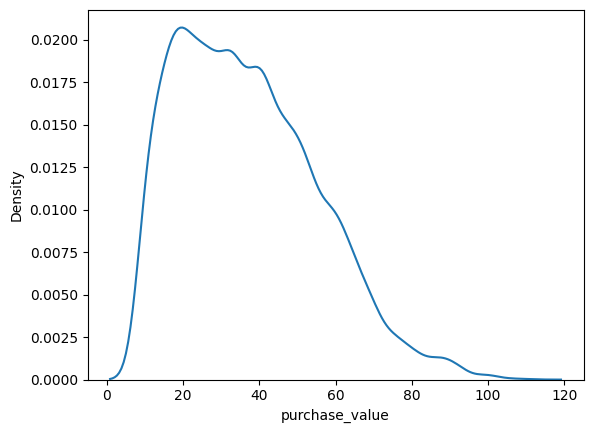

In [58]:
sns.kdeplot(data=df[fraud], x="purchase_value")

/var/folders/l3/pxhbl0b94cdd7tr_xs9sbypc0000gn/T/ipykernel_1516/913482835.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.kdeplot(data=df[non_fraud], x="purchase_value")


<Axes: xlabel='purchase_value', ylabel='Density'>

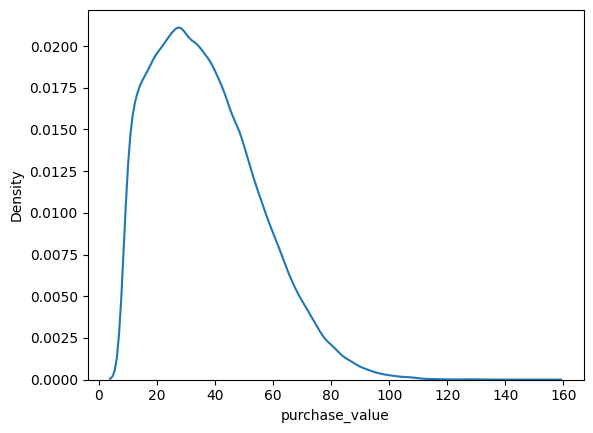

In [59]:
sns.kdeplot(data=df[non_fraud], x="purchase_value")

In [60]:
import pandas as pd

# Aggregate purchase_value by device_id
device_stats = df.groupby('device_id')['purchase_value'].agg(
    total_value='sum',
    mean_value='mean',
    median_value='median',
    min_value='min',
    max_value='max',
    std_value='std',
    count='count'
).reset_index()

device_stats[device_stats["std_value"] > 0].sort_values(["max_value", "std_value"], ascending=False)

,device_id,total_value,mean_value,median_value,min_value,max_value,std_value,count
40039,HPPPURWQPXJUG,144,72.000000,72.0,16,128,79.195959,2
107657,UHULJOWDWFCDT,134,67.000000,67.0,9,125,82.024387,2
96240,SDKPJUAARGGBM,136,68.000000,68.0,21,115,66.468037,2
35985,GUYJEOMVXXHHK,125,62.500000,62.5,12,113,71.417785,2
67739,MVVFZQTTYUVVT,145,72.500000,72.5,34,111,54.447222,2
...,...,...,...,...,...,...,...,...
30075,FRNHHKYPEDMKC,20,10.000000,10.0,9,11,1.414214,2
82943,PQYGRFTPGOLHI,20,10.000000,10.0,9,11,1.414214,2
137391,ZWZQCBJCNZFOY,20,10.000000,10.0,9,11,1.414214,2
86833,QKGYWSCYLQVNG,21,10.500000,10.5,10,11,0.707107,2


In [61]:
device_stats[device_stats["count"]==20]

,device_id,total_value,mean_value,median_value,min_value,max_value,std_value,count
14100,CQTUVBYIWWWBC,644,32.20,32.0,32,36,0.894427,20
24607,EQYVNEGOFLAWK,1369,68.45,67.0,67,96,6.484597,20
46203,ITUMJCKWEYNDD,760,38.00,38.0,38,38,0.000000,20
54521,KIPFSCNUGOLDP,1160,58.00,58.0,58,58,0.000000,20
69916,NGQCKIADMZORL,840,42.00,42.0,42,42,0.000000,20
136873,ZUSVMDEZRBDTX,940,47.00,47.0,47,47,0.000000,20


In [62]:
df[df["device_id"] == "KIPFSCNUGOLDP"]

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,...,users_by_device_id,users_by_ip_address,country,devices_by_ip,ip_by_device,device_ip_consistency,device_ip_user_consistency,time_between_setup_and_transaction,time_diff_device_id,time_diff_ip_address
45375,45375,221913,2015-01-03 10:47:31,2015-01-03 10:47:32,58,KIPFSCNUGOLDP,SEO,Safari,F,36,...,20,20,United States,1,1,True,False,1.0,NaN,NaN
100762,100762,45046,2015-01-03 10:47:32,2015-01-03 10:47:33,58,KIPFSCNUGOLDP,SEO,Safari,F,36,...,20,20,United States,1,1,True,False,1.0,1.0,1.0
91458,91458,168557,2015-01-03 10:47:33,2015-01-03 10:47:34,58,KIPFSCNUGOLDP,SEO,Safari,F,36,...,20,20,United States,1,1,True,False,1.0,1.0,1.0
112251,112251,123600,2015-01-03 10:47:34,2015-01-03 10:47:35,58,KIPFSCNUGOLDP,SEO,Safari,F,36,...,20,20,United States,1,1,True,False,1.0,1.0,1.0
112822,112822,866,2015-01-03 10:47:35,2015-01-03 10:47:36,58,KIPFSCNUGOLDP,SEO,Safari,F,36,...,20,20,United States,1,1,True,False,1.0,1.0,1.0
40300,40300,289750,2015-01-03 10:47:36,2015-01-03 10:47:37,58,KIPFSCNUGOLDP,SEO,Safari,F,36,...,20,20,United States,1,1,True,False,1.0,1.0,1.0
133124,133124,228507,2015-01-03 10:47:37,2015-01-03 10:47:38,58,KIPFSCNUGOLDP,SEO,Safari,F,36,...,20,20,United States,1,1,True,False,1.0,1.0,1.0
75008,75008,124779,2015-01-03 10:47:38,2015-01-03 10:47:39,58,KIPFSCNUGOLDP,SEO,Safari,F,36,...,20,20,United States,1,1,True,False,1.0,1.0,1.0
2070,2070,103009,2015-01-03 10:47:39,2015-01-03 10:47:40,58,KIPFSCNUGOLDP,SEO,Safari,F,36,...,20,20,United States,1,1,True,False,1.0,1.0,1.0
148149,148149,255957,2015-01-03 10:47:40,2015-01-03 10:47:41,58,KIPFSCNUGOLDP,SEO,Safari,F,36,...,20,20,United States,1,1,True,False,1.0,1.0,1.0


In [63]:
df[df["device_id"] == "CQTUVBYIWWWBC"]

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,...,users_by_device_id,users_by_ip_address,country,devices_by_ip,ip_by_device,device_ip_consistency,device_ip_user_consistency,time_between_setup_and_transaction,time_diff_device_id,time_diff_ip_address
100992,100992,366976,2015-01-04 15:01:47,2015-01-04 15:01:48,32,CQTUVBYIWWWBC,SEO,IE,F,42,...,20,19,United States,1,2,False,False,1.0,NaN,NaN
135302,135302,266507,2015-01-04 15:01:48,2015-01-04 15:01:49,32,CQTUVBYIWWWBC,SEO,IE,F,42,...,20,19,United States,1,2,False,False,1.0,1.0,1.0
7734,7734,109461,2015-01-04 15:01:49,2015-01-04 15:01:50,32,CQTUVBYIWWWBC,SEO,IE,F,42,...,20,19,United States,1,2,False,False,1.0,1.0,1.0
137947,137947,330014,2015-01-04 15:01:50,2015-01-04 15:01:51,32,CQTUVBYIWWWBC,SEO,IE,F,42,...,20,19,United States,1,2,False,False,1.0,1.0,1.0
150265,150265,46958,2015-01-04 15:01:51,2015-01-04 15:01:52,32,CQTUVBYIWWWBC,SEO,IE,F,42,...,20,19,United States,1,2,False,False,1.0,1.0,1.0
50877,50877,293871,2015-01-04 15:01:52,2015-01-04 15:01:53,32,CQTUVBYIWWWBC,SEO,IE,F,42,...,20,19,United States,1,2,False,False,1.0,1.0,1.0
67351,67351,29567,2015-01-04 15:01:53,2015-01-04 15:01:54,32,CQTUVBYIWWWBC,SEO,IE,F,42,...,20,19,United States,1,2,False,False,1.0,1.0,1.0
28035,28035,66663,2015-01-04 15:01:54,2015-01-04 15:01:55,32,CQTUVBYIWWWBC,SEO,IE,F,42,...,20,19,United States,1,2,False,False,1.0,1.0,1.0
12607,12607,21149,2015-01-04 15:01:55,2015-01-04 15:01:56,32,CQTUVBYIWWWBC,SEO,IE,F,42,...,20,19,United States,1,2,False,False,1.0,1.0,1.0
116535,116535,368124,2015-01-04 15:01:56,2015-01-04 15:01:57,32,CQTUVBYIWWWBC,SEO,IE,F,42,...,20,19,United States,1,2,False,False,1.0,1.0,1.0


In [64]:
purchase_value_by_device_count = device_stats.groupby("count")["mean_value"].mean()
purchase_value_std_by_device_count = device_stats.groupby("count")["std_value"].mean()

In [65]:
purchase_value_by_device_count

count
1     36.928867
2     37.005819
3     37.622222
4     38.312500
5     32.507692
6     34.971264
7     34.828571
8     34.871377
9     39.252137
10    36.468478
11    34.423942
12    38.137963
13    37.907452
14    35.136591
15    37.668293
16    39.336806
17    33.208145
18    45.927778
19    30.800000
20    47.608333
Name: mean_value, dtype: float64

In [66]:
purchase_value_std_by_device_count

count
1           NaN
2     14.345494
3     16.800396
4      4.130047
5      0.619219
6      0.520869
7      0.294812
8      0.210082
9      0.282051
10     0.360912
11     0.119410
12     0.336788
13     0.372689
14     0.595477
15     1.026498
16     0.529070
17     1.212678
18     0.306413
19     0.000000
20     1.229837
Name: std_value, dtype: float64

<Axes: xlabel='purchase_time', ylabel='Density'>

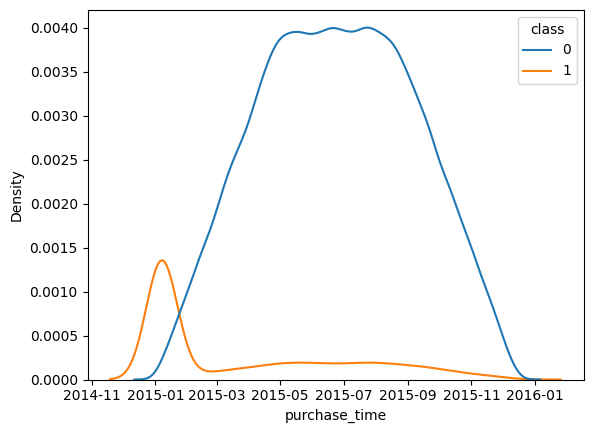

In [67]:
sns.kdeplot(data=df, x="purchase_time", hue="class")

Most of the fraudulent transactions were made in the early 2015, while non-fraudulent transactions peaked between 2015-04 to 2015-09

## Profile Customers by Clustering them based on:
- `sex`
- `age`
- `purchase_value`
- `gdp`

### Add `gdp` Column
- GDP by country and year data found at: https://datacatalog.worldbank.org/search/dataset/0037798

In [68]:
country_gdp_2015 = pd.read_excel("data/gdp_usd.xlsx", index_col=0).loc[2015.0,].to_dict()

In [97]:
def caculate_country_mean():
    counts = 0
    value = 0
    for country, gdp in country_gdp_2015.items():
        if "EMDE" not in country or "Countries" not in country or country != "World (WBG members)":
            if not pd.isna(gdp):
                counts += 1
                value += gdp

    return value / counts

impute_value = caculate_country_mean()

In [98]:
impute_value

3040975.7022815538

In [69]:
df["gdp"] = df["country"].apply(lambda x: country_gdp_2015.get(x, np.nan) if x else np.nan)

In [70]:
df["gdp"].value_counts(dropna=False)

gdp
18295100.00    58049
NaN            31174
11163825.00    12038
4446613.00      7306
2930444.00      4490
               ...  
21139.57           9
14943.16           7
11621.52           6
32186.51           5
13566.61           3
Name: count, Length: 84, dtype: int64

In [71]:
df[df["gdp"].isna()].country.value_counts().index

Index(['Korea Republic of', 'Taiwan; Republic of China (ROC)', 'Viet Nam',
       'Hong Kong', 'Iran (ISLAMIC Republic Of)', 'Egypt', 'Venezuela',
       'European Union', 'Pakistan', 'Algeria', 'United Arab Emirates',
       'Seychelles', 'Slovakia (SLOVAK Republic)',
       'Croatia (LOCAL Name: Hrvatska)', 'Panama', 'Dominican Republic',
       'Oman', 'Bangladesh', 'Moldova Republic of', 'Puerto Rico',
       'Bosnia and Herzegowina', 'Lebanon', 'Qatar', 'Sudan', 'Macedonia',
       'Angola', 'Syrian Arab Republic', 'Azerbaijan', 'Namibia',
       'Trinidad and Tobago', 'Iraq', 'Nepal', 'Kyrgyzstan',
       'Palestinian Territory Occupied', 'Mozambique', 'Cambodia', 'Rwanda',
       'Tanzania United Republic of', 'Libyan Arab Jamahiriya', 'Uganda',
       'Zambia', 'Macau', 'Gabon', 'Cuba', 'Barbados', 'Senegal', 'Belize',
       'Malawi', 'Brunei Darussalam', 'Guam', 'Montenegro', 'Zimbabwe',
       'Afghanistan', 'Cote D'ivoire', 'New Caledonia', 'Papua New Guinea',
       'Lao P

### Refine mapping of gdp to country by Normalising Country Names

In [83]:
country_map = {
    "Korea Republic of": "Korea, Rep.",
    "Taiwan; Republic of China (ROC)": "Taiwan, China",
    "Hong Kong": "Hong Kong SAR, China",
    "Egypt": "Egypt, Arab Rep.",
    "Slovakia": "Slovakia (SLOVAK Republic)",
    "Croatia": "Croatia (LOCAL Name: Hrvatska)",
    "Oman": "EMDE Middle East, North Africa, Afghanistan & Pakistan",
    "Moldova Republic of": "Moldova, Rep.",
    "Bosnia and Herzegowina": "Bosnia and Herzegovina",
    "Macedonia": "North Macedonia"
}

def get_country_gdp(country):
    if country not in country_gdp_2015 and country in country_map:
        print(country)
        country = country_map[country]
    
    return country_gdp_2015.get(country, np.nan)

In [101]:
df["gdp"] = df["country"].apply(
    lambda x: country_gdp_2015.get(x, country_gdp_2015.get(country_map.get(x))) if x in country_gdp_2015 or x in country_map else impute_value
)

K = 16 was chosen based on intuitive segmentation across four binary-like dimensions (age, spending, GDP, gender), producing interpretable customer groups such as “Young High Spenders from High-GDP countries” or “Older Low Spenders from Low-GDP regions.”

In [116]:
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors

def dbscan_search(features):
    neighbours = NearestNeighbors(n_neighbors=5)
    neighbours_fit = neighbours.fit(features)
    distances, indices = neighbours_fit.kneighbors(features)

    # Sort the distances to find the “knee”
    distances = np.sort(distances[:, -1])
    plt.plot(distances)
    plt.xlabel("Points sorted by distance")
    plt.ylabel("8th Nearest Neighbor Distance")
    plt.title("Elbow Method for DBSCAN Epsilon")
    plt.show()

    knee = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
    eps_optimal = distances[knee.knee]
    return eps_optimal

def cluster_customers(df, clustering_model, *features):
    cluster_df = df.copy()[["sex", "purchase_value", "age", "gdp"]]

    numeric = ["age", "purchase_value", "gdp"]
    categorical = ["sex"]

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), numeric),
        ("cat", OneHotEncoder(drop="first"), categorical)
    ])

    X = preprocessor.fit_transform(cluster_df)

    if clustering_model == "DBSCAN":
        # 2 <= min_samples <= 2 * dim
        eps = dbscan_search(X)
        model = DBSCAN(eps, min_samples=2*4)
    elif clustering_model == "KMeans":
        model = KMeans(n_clusters=16, random_state=42)

    labels = model.fit_predict(X)
    return X, labels


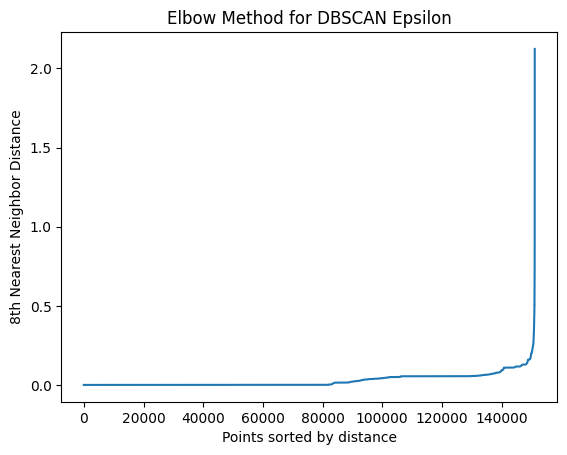

In [117]:
X, dbscan_labels = cluster_customers(df, "DBSCAN")
_, kmeans_labels = cluster_customers(df, "KMeans")

### Evaluate Clustering Performance

Silhouette Score
- Measures how similar a data point is to its own cluster compared to other clusters.
- Ranges from -1 to 1, where 1 indicates well-separated and dense clusters, 0 indicates overlapping clusters, and -1 suggests incorrect assignments.

In [118]:
from sklearn.metrics import silhouette_score

print("Silhouette (K-Means):", silhouette_score(X, kmeans_labels))
print("Silhouette (DBSCAN):", silhouette_score(X, dbscan_labels))

Silhouette (K-Means): 0.24005536690923163
Silhouette (DBSCAN): 0.13747737364517457


Visualisation
- Project features used for clustering into a 2D space
- Plot graph of PCA feature 1 against PCA feature 2, and colour by cluster labels

In [119]:
from sklearn.decomposition import PCA

def visualise_clusters_pca(X, labels):
    pca = PCA(2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8,4))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='rainbow', s=5)
    plt.title('DBSCAN Clusters')
    plt.show()

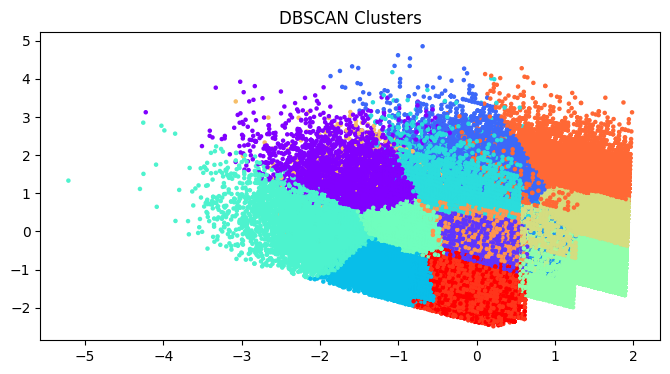

In [120]:

visualise_clusters_pca(X, kmeans_labels)

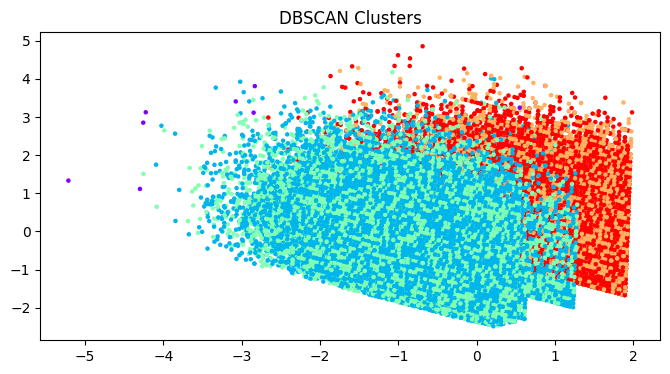

In [121]:
visualise_clusters_pca(X, dbscan_labels)

In [123]:
df["customer_group"] = kmeans_labels

In [134]:
df["is_male"] = df["sex"].apply(lambda x: 1 if x == "M" else 0)

In [135]:
df.groupby("customer_group")[["purchase_value", "age", "gdp", "is_male"]].mean()

,purchase_value,age,gdp,is_male
customer_group,,,,
0,60.504352,44.075692,2.465476e+06,0.549270
1,21.710288,36.271243,2.240962e+06,1.000000
2,53.058195,41.253959,1.723715e+07,0.589818
3,41.786376,27.426646,1.707723e+07,0.000000
4,48.327237,23.765183,2.267826e+06,0.601663
5,29.018008,48.691839,2.197305e+06,0.670346
6,72.921289,29.595704,2.224688e+06,0.574062
7,45.202785,34.496652,2.201451e+06,0.668696
8,20.027372,24.589761,1.701850e+07,0.613500
